In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from warnings import filterwarnings
import operator
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import spacy
from textblob import TextBlob
from textblob import Word

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
filterwarnings(action='ignore')
plt.style.use('ggplot')
pal = sns.color_palette()

In [4]:
nltk.download('stopwords')
lem = spacy.load('en_core_web_sm')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
train_df = pd.read_csv('/content/drive/My Drive/dataset/train.csv')
test_df = pd.read_csv('/content/drive/My Drive/dataset/test.csv')

In [6]:
train_df.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:41.987077+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:42.870083+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:45.222647+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:47.601894+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-09-29 10:50:48.488476+00,2,NaN,2006,rejected,0,0,0,1,0,0.0,4,47


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1804874 entries, 0 to 1804873
Data columns (total 45 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   id                                   int64  
 1   target                               float64
 2   comment_text                         object 
 3   severe_toxicity                      float64
 4   obscene                              float64
 5   identity_attack                      float64
 6   insult                               float64
 7   threat                               float64
 8   asian                                float64
 9   atheist                              float64
 10  bisexual                             float64
 11  black                                float64
 12  buddhist                             float64
 13  christian                            float64
 14  female                               float64
 15  heterosexual                    

In [8]:
train_df.describe()

,id,target,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,publication_id,parent_id,article_id,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
count,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.00000,1.804874e+06,1.026228e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06
mean,3.738434e+06,1.030173e-01,4.582099e-03,1.387721e-02,2.263571e-02,8.115273e-02,9.311271e-03,0.011964,0.003205,0.001884,0.034393,0.001410,0.095268,0.127670,0.003237,0.001457,0.025611,0.001088,0.017863,0.006127,0.108687,0.049460,0.001220,0.000884,0.008248,0.006761,0.001494,0.001356,0.012083,0.006724,0.05695,4.986296e+01,3.722687e+06,2.813597e+05,2.779269e-01,4.420696e-02,1.091173e-01,2.446167e+00,5.843688e-01,6.605974e-03,1.439019e+00,8.784694e+00
std,2.445187e+06,1.970757e-01,2.286128e-02,6.460419e-02,7.873156e-02,1.760657e-01,4.942218e-02,0.087166,0.050193,0.026077,0.167900,0.030923,0.256671,0.305384,0.045801,0.030862,0.143739,0.016032,0.122145,0.058684,0.267894,0.202459,0.014102,0.011853,0.042717,0.037504,0.015374,0.017505,0.089183,0.069027,0.21596,2.769869e+01,2.450261e+06,1.039293e+05,1.055313e+00,2.449359e-01,4.555363e-01,4.727924e+00,1.866589e+00,4.529782e-02,1.787041e+01,4.350086e+01
min,5.984800e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,2.000000e+00,6.100600e+04,2.006000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00
25%,7.969752e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,2.100000e+01,7.960188e+05,1.601200e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
50%,5.223774e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,5.400000e+01,5.222993e+06,3.321260e+05,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
75%,5.769854e+06,1.666667e-01,0.000000e+00,0.000000e+00,0.000000e+00,9.090909e-02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,5.400000e+01,5.775758e+06,3.662370e+05,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00
max,6.334010e+06,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1

In [9]:
# nan check

train_df.isnull().sum().sort_values()

id                                           0
sexual_explicit                              0
disagree                                     0
likes                                        0
sad                                          0
wow                                          0
funny                                        0
rating                                       0
article_id                                   0
publication_id                               0
created_date                                 0
identity_annotator_count                     0
toxicity_annotator_count                     0
target                                       0
comment_text                                 0
severe_toxicity                              0
obscene                                      0
identity_attack                              0
insult                                       0
threat                                       0
parent_id                               778646
christian    

In [10]:
test_df.isnull().sum().sort_values()

id              0
comment_text    0
dtype: int64

In [11]:
train_df.duplicated().sum()

0

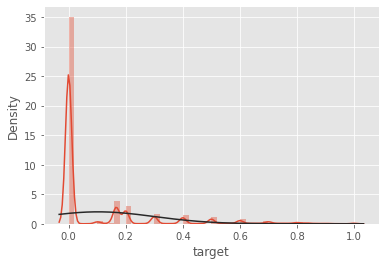

In [12]:
# checking target distribution

sns.distplot(train_df['target'], fit=stats.norm)

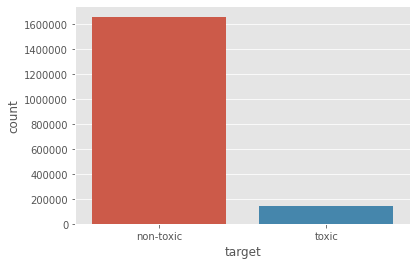

In [13]:
# checking it in the other way

temp = train_df['target'].apply(lambda x: 'toxic' if x >= 0.5 else 'non-toxic')
sns.countplot(temp)
plt.ticklabel_format(style='plain', axis='y')

In [14]:
# checking relation between each identity and the level of toxivity

toxics = train_df[train_df.columns[8:32]]
identities = []
for col in toxics.columns:
    temp = toxics[col].dropna()
    identities.append(sum(temp)/len(temp))

toxicity_mean_rate = pd.DataFrame(
    {'identities': list(toxics.columns), 'toxicity_rate': identities})
toxicity_mean_rate.sort_values('toxicity_rate', ascending=False, inplace=True)

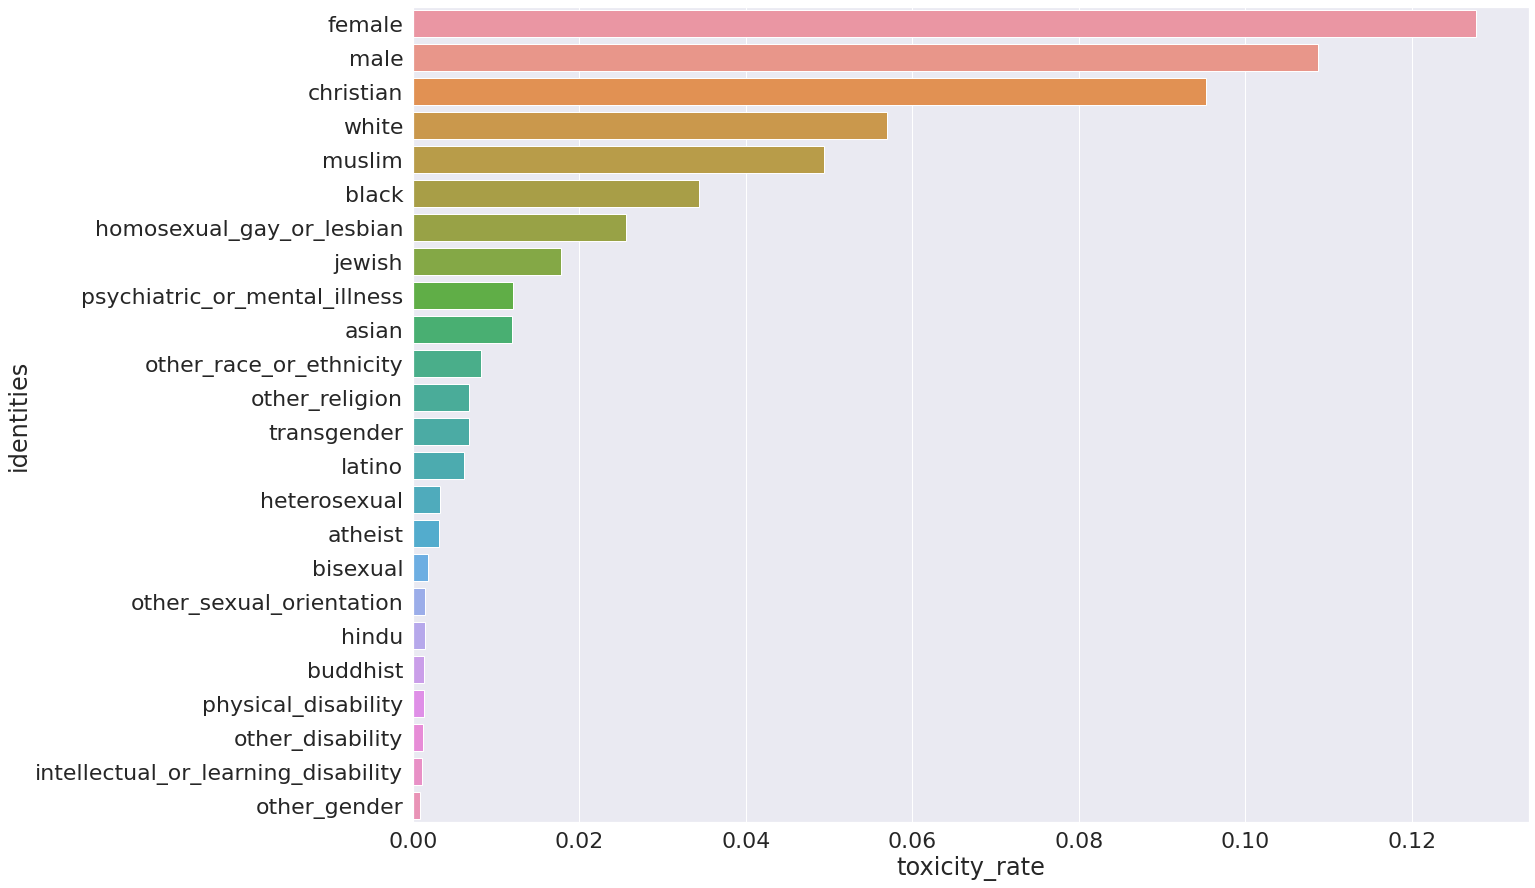

In [15]:
plt.figure(figsize=(20, 15))
sns.set(font_scale=2)
sns.barplot(x=toxicity_mean_rate['toxicity_rate'],
            y=toxicity_mean_rate['identities'])

## Text cleaning

In [16]:
train = train_df[['id', 'target', 'comment_text']]

In [17]:
manual_stopwords = ['i', 'am', 'would', 'could', 'can', 'will', 'is', 'are', 'be', 'to', 'us', 'their', 'they', 'you',
                    'your', 'by', 'go', 'do', 'at', 'on', 'hi', 'if', 'me', 'my', 'mine', 'of', 'in', 'ok', 'so', 'up',
                    'for', 'have', 'yes', 'no', 'sure', 'lot', 'little', 'a bit', 'yet']

In [18]:
RE_PATTERNS = {
    ' american ':
        [
            'amerikan'
        ],
    ' loser ':
        [
            'L0ser', 'loser'
        ],
    ' adolf ':
        [
            'adolf'
        ],


    ' hitler ':
        [
            'hitler'
        ],

    ' fuck':
        [
            '(f)(u|[^a-z0-9 ])(c|[^a-z0-9 ])(k|[^a-z0-9 ])([^ ])*',
            '(f)([^a-z]*)(u)([^a-z]*)(c)([^a-z]*)(k)',
            ' f[!@#\$%\^\&\*]*u[!@#\$%\^&\*]*k', 'f u u c',
            '(f)(c|[^a-z ])(u|[^a-z ])(k)', r'f\*',
            'feck ', ' fux ', 'f\*\*', 'f**k', 'fu*k',
            'f\-ing', 'f\.u\.', 'f###', ' fu ', 'f@ck', 'f u c k', 'f uck', 'f ck'
        ],

    ' ass ':
        [
            '[^a-z]ass ', '[^a-z]azz ', 'arrse', ' arse ', '@\$\$',
            '[^a-z]anus', ' a\*s\*s', '[^a-z]ass[^a-z ]',
            'a[@#\$%\^&\*][@#\$%\^&\*]', '[^a-z]anal ', 'a s s', 'a55', '@$$'
        ],

    ' asshole ':
        [
            ' a[s|z]*wipe', 'a[s|z]*[w]*h[o|0]+[l]*e', '@\$\$hole', 'a**hole', 'ass hole'
        ],

    ' bitch ':
        [
            'b[w]*i[t]*ch', 'b!tch',
            'bi\+ch', 'b!\+ch', '(b)([^a-z]*)(i)([^a-z]*)(t)([^a-z]*)(c)([^a-z]*)(h)',
            'biatch', 'bi\*\*h', 'bytch', 'b i t c h', 'b!tch', 'bi+ch', 'l3itch'
        ],

    ' bastard ':
        [
            'ba[s|z]+t[e|a]+rd'
        ],

    ' transgender':
        [
            'transgender', 'trans gender'
        ],

    ' gay ':
        [
            'gay', 'geh', 'gae'
        ],

    ' cock ':
        [
            '[^a-z]cock', 'c0ck', '[^a-z]cok ', 'c0k', '[^a-z]cok[^aeiou]', ' cawk',
            '(c)([^a-z ])(o)([^a-z ]*)(c)([^a-z ]*)(k)', 'c o c k'
        ],

    ' dick ':
        [
            ' dick[^aeiou]', 'deek', 'd i c k', 'dik'
        ],

    ' suck ':
        [
            'sucker', '(s)([^a-z ]*)(u)([^a-z ]*)(c)([^a-z ]*)(k)', 'sucks', '5uck', 's u c k'
        ],

    ' cunt ':
        [
            'cunt', 'c u n t'
        ],

    ' bullshit ':
        [
            'bullsh\*t', 'bull\$hit', 'bullshit'
        ],

    ' homosexual':
        [
            'homosexual', 'homo'
        ],

    ' jerk ':
        [
            'jerk'
        ],

    ' idiot ':
        [
            'i[d]+io[t]+', '(i)([^a-z ]*)(d)([^a-z ]*)(i)([^a-z ]*)(o)([^a-z ]*)(t)', 'idiots'
                                                                                      'i d i o t'
        ],

    ' dumb ':
        [
            '(d)([^a-z ]*)(u)([^a-z ]*)(m)([^a-z ]*)(b)'
        ],

    ' shit ':
        [
            'shitty', '(s)([^a-z ]*)(h)([^a-z ]*)(i)([^a-z ]*)(t)', 'shite', '\$hit', 's h i t', '$h1t', 'shtty'
        ],

    ' shithole ':
        [
            'shythole', 'shit hole'
        ],

    ' retard ':
        [
            'returd', 'retad', 'retard', 'wiktard', 'wikitud'
        ],

    ' rape ':
        [
            ' raped'
        ],

    ' dumbass':
        [
            'dumb ass', 'dubass'
        ],

    ' asshead':
        [
            'butthead', 'butt head'
        ],
    ' dickhead':
        [
            'dick head'
        ],

    ' sex ':
        [
            'sexy', 's3x', 'sexuality'
        ],


    ' nigger ':
        [
            'nigger', 'ni[g]+a', ' nigr ', 'negrito', 'niguh', 'n3gr', 'n i g g e r'
        ],

    ' shut the fuck up':
        [
            'stfu', 'st*u'
        ],

    ' pussy ':
        [
            'pussy[^c]', 'pusy', 'pussi[^l]', 'pusses', 'p*ssy'
        ],

    ' faggot ':
        [
            'faggot', ' fa[g]+[s]*[^a-z ]', 'fagot', 'f a g g o t', 'faggit',
            '(f)([^a-z ]*)(a)([^a-z ]*)([g]+)([^a-z ]*)(o)([^a-z ]*)(t)', 'fau[g]+ot', 'fae[g]+ot',
        ],

    ' motherfucker':
        [
            ' motha ', ' motha f', ' mother f', 'motherfucker',
        ],

    ' whore ':
        [
            'wh\*\*\*', 'w h o r e'
        ],
    ' fucking ':
        [
            'f*$%-ing',
        ],
    ' suck my dick ':
        [
            'smd'
        ],
}

In [20]:
def text_cleaner(text):
    # discarding non-english sentences
    t = re.sub('[^a-zA-Z0-9]', ' ', text)
    text = re.sub('\s+', ' ', t)

    # lowercasing
    text = text.lower()

    # removing urls and html tags
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>', '', text)

    # removing repeating characters but not changing words' meanings
    rx = re.compile(r'([^\W\d_])\1{2,}')
    text = re.sub(r'[^\W\d_]+', lambda x: Word(rx.sub(r'\1\1', x.group())).correct()
                  if rx.search(x.group()) else x.group(), text)

    # removing emojies
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"
                               u"\U0001F300-\U0001F5FF"
                               u"\U0001F680-\U0001F6FF"
                               u"\U0001F1E0-\U0001F1FF"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    # replacing newlines with spaces
    text = str(text).replace('\n', ' ')

    # replacing cuss words with their actual forms
    for real, patterns in RE_PATTERNS.items():
        for pattern in patterns:
            text = str(text).replace(pattern, real)

    # removing punctuations
    text = ''.join([word for word in text if word not in string.punctuation])

    # removing stopwords
    stops = stopwords.words('english')
    stops = manual_stopwords + list(stops)
    tokens = word_tokenize(text)
    no_stops = [x for x in tokens if x not in stops]

    # lemmatization
    doc = spacy.tokens.Doc(lem.vocab, words=no_stops)
    reverted_to_base = []
    for token in doc:
        reverted_to_base.append(token.lemma_)
    text = ' '.join(reverted_to_base)

    return text

In [21]:
# cleaning
train['comment_text'] = train['comment_text'].apply(lambda x: text_cleaner(x))
test_df['comment_text'] = test_df['comment_text'].apply(
    lambda x: text_cleaner(x))

In [22]:
train

,id,target,comment_text
0,59848,0.000000,cool like want mother read really great idea g...
1,59849,0.000000,thank make life little anxiety induce keep let...
2,59852,0.000000,urgent design problem kudo take impressive
3,59855,0.000000,something able install site release
4,59856,0.893617,haha guy bunch loser
...,...,...,...
1804869,6333967,0.000000,maybe tax thing collect product import registe...
1804870,6333969,0.000000,call people still think divine role creation
1804871,6333982,0.000000,thank right wrong follow advice
1804872,6334009,0.621212,anyone quote follow exchange even apocryphal r...


In [23]:
non_engs = train[train['comment_text'] == ' '].index
train.drop(non_engs, inplace=True)

In [24]:
def wordcloud_plot(df, target):
    # 1: toxic, 0 non-toxics
    # any number except these are counted as number of samples you wanna get from comment_text
    if target == 1:
        words = []
        for x in df[df['target'] >= 0.5]['comment_text'].str.split():
            for i in x:
                words.append(i)
    elif target == 0:
        words = []
        for x in df[df['target'] < 0.5]['comment_text'].str.split():
            for i in x:
                words.append(i)
    else:
        words = df['comment_text'].sample(target)

    # plotting
    plt.figure(figsize=(12, 8))
    word_cloud = WordCloud(
        background_color='white',
        max_font_size=80
    ).generate(" ".join(words[:50]))
    plt.imshow(word_cloud)
    plt.axis('off')
    plt.show()

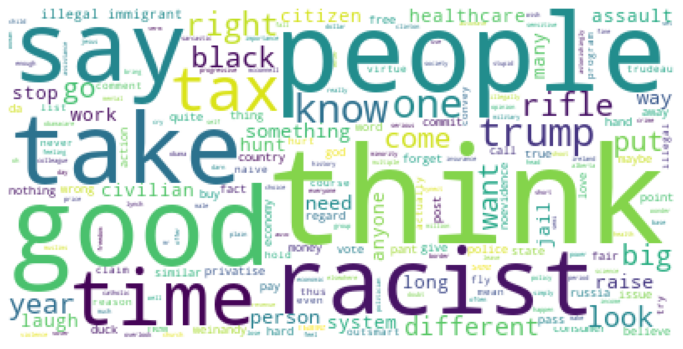

In [25]:
wordcloud_plot(train, 1500)

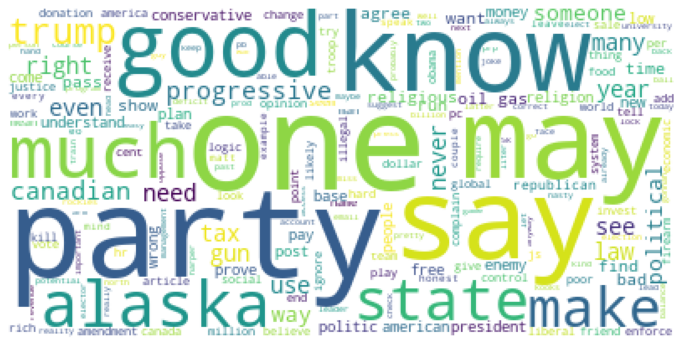

In [26]:
wordcloud_plot(test_df, 2000)

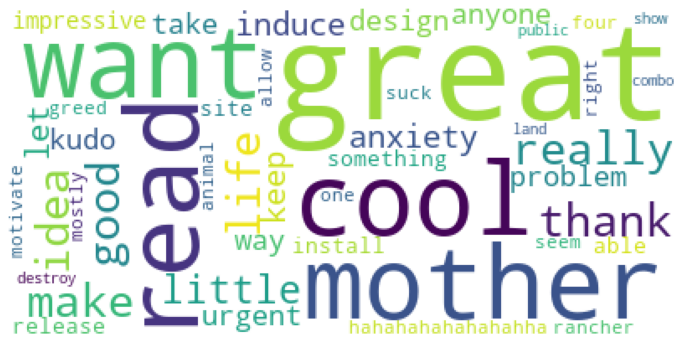

In [27]:
wordcloud_plot(train, 0)

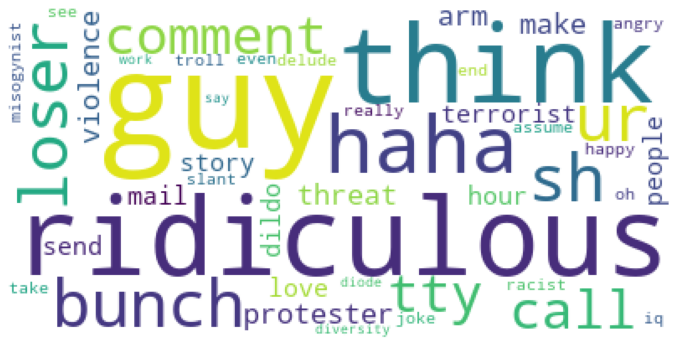

In [28]:
wordcloud_plot(train, 1)

In [29]:
def cuss_word_counter(text):
    tokens = word_tokenize(text)
    cuss_words = list(map(str.strip, RE_PATTERNS.keys()))
    cuss_counter = 0
    for word in cuss_words:
        if word in tokens:
            cuss_counter += 1
    return cuss_counter

In [35]:
train['num_of_cuss_words'] = 0
test_df['num_of_cuss_words'] = 0
train['num_of_cuss_words'] = train['comment_text'].apply(
    lambda x: cuss_word_counter(x))
test_df['num_of_cuss_words'] = test_df['comment_text'].apply(
    lambda x: cuss_word_counter(x))

In [44]:
train['target'].corr(train['num_of_cuss_words'])

0.24656068846909895